# Lecture 7:  Regularization
### Data Science 1: CS 109A/STAT 121A/AC 209A/ E 109A <br> Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine
#### Harvard University <br> Fall 2017 <br> 

---


In [1]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import RegressionResults
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
sns.set(style="ticks")
%matplotlib inline

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
nyc_cab_df = pd.read_csv('data/nyc_car_hire_data.csv', low_memory=False)

In [24]:
def train_test_split(df, n_samples, validation=False):
    if validation:
        nyc_cab_sample = df.sample(n=n_samples)

        nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
        nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)

        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        non_test = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]
        
        msk = np.random.rand(len(non_test)) < 0.7
        train = non_test[msk]
        validation = non_test[~msk]
        
        return train, validation, test
    
    else:
        nyc_cab_sample = df.sample(n=n_samples)

        nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
        nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)

        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        train = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]

        return train, test

---

## Comparing Ridge and LASSO Regression

In [25]:
train, validation, test = train_test_split(nyc_cab_df, 5000, validation=True)

y_train = train['Fare_amount'].values
y_val = validation['Fare_amount'].values
y_test = test['Fare_amount'].values

regression_model = LinearRegression(fit_intercept=True)

all_predictors = ['Trip Length (min)', 'Type', 'Trip_distance', 'TMAX', 'TMIN', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude', 'Pickup_latitude', 'SNOW', 'SNWD', 'PRCP']

### 1. Variable Selection: Backwards Using AIC

In [27]:
def get_aic(X_train, y_train):
    X_train = add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model.aic

X_train = train[all_predictors].values
predictors = [(all_predictors, get_aic(X_train, y_train))]

for k in range(len(all_predictors), 1, -1):
    best_k_predictors = predictors[-1][0]
    aics = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = train[k_minus_1].values

        aics.append(get_aic(X_train, y_train))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(aics)]]))
    predictors.append((best_k_minus_1, np.min(aics)))
    
best_predictor_set = sorted(predictors, key=lambda t: t[1])[-1]


In [28]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[0]

X_train = train[best_predictor_set[0]].values
X_val = validation[best_predictor_set[0]].values  
X_test = test[best_predictor_set[0]].values  
regression_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('best predictor set: {}\naic: {}\ntest R^2: {}'.format(best_predictor_set[0], best_predictor_set[1], regression_model.score(X_test, y_test)))

best predictor set: ['lpep_pickup_datetime', 'Trip_distance', 'Trip Length (min)', 'Type', 'SNWD', 'SNOW']
aic: 15308.456891052894
test R^2: 0.7896078581232107


### 2. Ridge Regression

In [33]:
X_train = train[all_predictors].values
X_val = validation[all_predictors].values
X_test = test[all_predictors].values

ridge_regression = Ridge(alpha=1.0, fit_intercept=True)
ridge_regression.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('Ridge regression model:\n {} + {}^T . x'.format(ridge_regression.intercept_, ridge_regression.coef_))

Ridge regression model:
 1.1203446112390303 + [  3.01373329e-01   9.00351806e+00   2.06750603e+00  -1.14801248e-02
   4.23355593e-03   2.02290609e-02  -6.97961547e-03   4.74016520e-01
   9.06460927e-01   0.00000000e+00   0.00000000e+00  -9.84083386e-02]^T . x


In [34]:
print('Train R^2: {}, test R^2: {}'.format(ridge_regression.score(np.vstack((X_train, X_val)), 
                                                                  np.hstack((y_train, y_val))), 
                                           ridge_regression.score(X_test, y_test)))

Train R^2: 0.8128187525312068, test R^2: 0.7894042287406281


### 3. LASSO Regression

In [35]:
lasso_regression = Lasso(alpha=1.0, fit_intercept=True)
lasso_regression.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('Lasso regression model:\n {} + {}^T . x'.format(lasso_regression.intercept_, lasso_regression.coef_))

Lasso regression model:
 4.930863668592476 + [  2.92178998e-01   4.09638866e+00   1.91699827e+00  -7.39241744e-03
  -0.00000000e+00   3.79642192e-03   5.70222315e-03  -0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]^T . x


In [36]:
print('Train R^2: {}, test R^2: {}'.format(lasso_regression.score(np.vstack((X_train, X_val)), 
                                                                  np.hstack((y_train, y_val))), 
                                           lasso_regression.score(X_test, y_test)))

Train R^2: 0.7495825495598774, test R^2: 0.7328914661774865


---

## The Effect of the Regularization Parameter

In [37]:
reg_params = np.hstack((10.**np.arange(-7, 0), 10**np.arange(0, 4) + 0.01))

### 1. Ridge Regression

In [38]:
train_R_sq = []
test_R_sq = []

for reg in reg_params:
    ridge_regression = Ridge(alpha=reg, fit_intercept=True)
    ridge_regression.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))
    
    train_R_sq.append(ridge_regression.score(np.vstack((X_train, X_val)), np.hstack((y_train, y_val))))
    test_R_sq.append(ridge_regression.score(X_test, y_test))

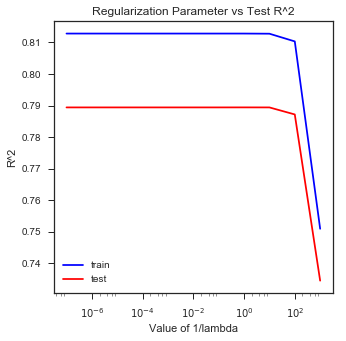

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(reg_params, train_R_sq, color='blue', label='train')
ax.plot(reg_params, test_R_sq, color='red', label='test')

ax.set_xscale('log')
ax.set_title('Regularization Parameter vs Test R^2')
ax.set_xlabel('Value of 1/lambda')
ax.set_ylabel('R^2')
ax.legend(loc='best')

plt.show()

### 2. LASSO Regression

In [40]:
train_R_sq = []
test_R_sq = []

for reg in reg_params:
    lasso_regression = Lasso(alpha=reg, fit_intercept=True)
    lasso_regression.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))
    
    train_R_sq.append(lasso_regression.score(np.vstack((X_train, X_val)), np.hstack((y_train, y_val))))
    test_R_sq.append(lasso_regression.score(X_test, y_test))

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


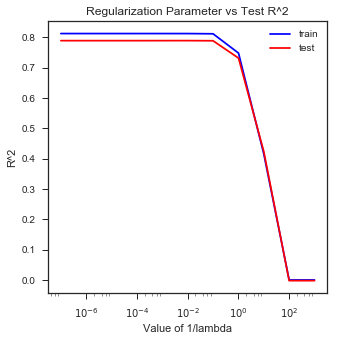

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(reg_params, train_R_sq, color='blue', label='train')
ax.plot(reg_params, test_R_sq, color='red', label='test')

ax.set_xscale('log')
ax.set_title('Regularization Parameter vs Test R^2')
ax.set_xlabel('Value of 1/lambda')
ax.set_ylabel('R^2')
ax.legend(loc='best')

plt.show()

---

## Cross Validation: Selecting the Regularization Parameter

In [42]:
X_non_test = np.vstack((X_train, X_val))
y_non_test = np.hstack((y_train, y_val))


kf = KFold(n_splits=10)

x_val_scores = []

for reg in reg_params:
    ridge_regression = Ridge(alpha=reg, fit_intercept=True)
    
    validation_R_sqs = []
    for train_index, val_index in kf.split(X_non_test):
        X_train, X_val = X_non_test[train_index], X_non_test[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        
        ridge_regression.fit(X_train, y_train)
        validation_R_sqs.append(ridge_regression.score(X_val, y_val))
        
    x_val_scores.append(np.mean(validation_R_sqs))

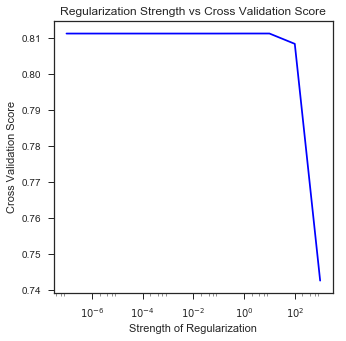

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(reg_params, x_val_scores, color='blue')

ax.set_xscale('log')
ax.set_title('Regularization Strength vs Cross Validation Score')
ax.set_xlabel('Strength of Regularization')
ax.set_ylabel('Cross Validation Score')

plt.show()

In [45]:
best_alpha = reg_params[np.argmax(x_val_scores)]

ridge_regression = Ridge(alpha=best_alpha, fit_intercept=True)
ridge_regression.fit(X_non_test, y_non_test)
test_R_sq = (ridge_regression.score(X_test, y_test))

print('best regularization param is:', best_alpha)
print('the test R^2 for ridge regression with alpha = {} is: {}'.format(best_alpha, test_R_sq))

best regularization param is: 1.01
the test R^2 for ridge regression with alpha = 1.01 is: 0.7894042889295461
